In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd

import torchvision
from torchvision.models import resnet18, ResNet18_Weights, vgg16, VGG16_Weights
from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


import os
from torchsummary import summary



# from google.colab import drive
# drive.mount('/content/drive')
# #Code folder path
# %cd /content/drive/My Drive/ECE591_DL_CL_PROJECT/

#device config
torch.cuda.set_device(1)#Select GPU device 1
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Datasets
#Tiny-imagenet: http://cs231n.stanford.edu/tiny-imagenet-200.zip
#Tiny-imagenet-C: https://zenodo.org/records/2469796

#CIFAR-10:  https://www.cs.toronto.edu/~kriz/cifar.html
#CIFAR-10C: https://zenodo.org/records/2535967


In [2]:
# Returns a list of transformations when called
class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #Normalize all the images
        ]
        return test_transforms

transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams()) 

In [3]:
#Create Loaders
DataPath="./Datasets/TINY-IMAGENET/tiny-imagenet-200"
trainset = datasets.ImageFolder(DataPath+'/train', transform=train_transforms)
testset = datasets.ImageFolder(DataPath+'/test_pro', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,shuffle=False, num_workers=2)


In [4]:
class Vgg16(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2, dilation=1)
        )
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=-1)

model = Vgg16(num_classes=200).to(device)
summary(model, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

In [5]:
def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):

    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target) #negative log likelihood loss


        train_losses.append(loss.item())
        loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update).

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):

    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0


    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified


In [7]:
# Training the model
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 50

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)

    #Save every multiple of 10 epochs
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/VGG16_TINY_IMAGENET_V0.pt")
        np.savez("./Networks/TrainSteps_VGG16_TinyImagenet_V0.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/VGG16_TINY_IMAGENET_V0.pt")
np.savez("./Networks/TrainSteps_VGG16_TinyImagenet_V0.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)   

EPOCHS : 0


Loss=1.182063102722168 Batch_id=390 Accuracy=72.78: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 



Test set: Average loss: 2.3670, Accuracy: 2390/5000 (47.80%)

EPOCHS : 1


Loss=0.9533551931381226 Batch_id=390 Accuracy=73.38: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]



Test set: Average loss: 2.4071, Accuracy: 2382/5000 (47.64%)

EPOCHS : 2


Loss=1.0637929439544678 Batch_id=390 Accuracy=75.76: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]



Test set: Average loss: 2.3907, Accuracy: 2442/5000 (48.84%)

EPOCHS : 3


Loss=0.9189238548278809 Batch_id=390 Accuracy=78.19: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]



Test set: Average loss: 2.3790, Accuracy: 2500/5000 (50.00%)

EPOCHS : 4


Loss=0.5941193103790283 Batch_id=390 Accuracy=80.02: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]



Test set: Average loss: 2.5201, Accuracy: 2422/5000 (48.44%)

EPOCHS : 5


Loss=0.5771953463554382 Batch_id=390 Accuracy=82.25: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s] 



Test set: Average loss: 2.5228, Accuracy: 2432/5000 (48.64%)

EPOCHS : 6


Loss=0.7309277653694153 Batch_id=390 Accuracy=84.22: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s] 



Test set: Average loss: 2.5219, Accuracy: 2464/5000 (49.28%)

EPOCHS : 7


Loss=0.7298625707626343 Batch_id=390 Accuracy=85.64: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s] 



Test set: Average loss: 2.5750, Accuracy: 2473/5000 (49.46%)

EPOCHS : 8


Loss=0.4553926885128021 Batch_id=390 Accuracy=87.44: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s] 



Test set: Average loss: 2.5159, Accuracy: 2511/5000 (50.22%)

EPOCHS : 9


Loss=0.34265705943107605 Batch_id=390 Accuracy=88.93: 100%|██████████| 391/391 [03:09<00:00,  2.07it/s]



Test set: Average loss: 2.5854, Accuracy: 2504/5000 (50.08%)

EPOCHS : 10


Loss=0.40911006927490234 Batch_id=390 Accuracy=90.41: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]



Test set: Average loss: 2.5749, Accuracy: 2516/5000 (50.32%)

EPOCHS : 11


Loss=0.3374766707420349 Batch_id=390 Accuracy=91.42: 100%|██████████| 391/391 [03:10<00:00,  2.06it/s] 



Test set: Average loss: 2.6288, Accuracy: 2505/5000 (50.10%)

EPOCHS : 12


Loss=0.30827203392982483 Batch_id=390 Accuracy=92.65: 100%|██████████| 391/391 [03:10<00:00,  2.06it/s]



Test set: Average loss: 2.5948, Accuracy: 2550/5000 (51.00%)

EPOCHS : 13


Loss=0.347482293844223 Batch_id=390 Accuracy=93.42: 100%|██████████| 391/391 [02:22<00:00,  2.74it/s]  



Test set: Average loss: 2.6728, Accuracy: 2541/5000 (50.82%)

EPOCHS : 14


Loss=0.208950474858284 Batch_id=390 Accuracy=94.08: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s]  



Test set: Average loss: 2.6267, Accuracy: 2580/5000 (51.60%)

EPOCHS : 15


Loss=0.24651160836219788 Batch_id=390 Accuracy=94.60: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s]



Test set: Average loss: 2.6722, Accuracy: 2601/5000 (52.02%)

EPOCHS : 16


Loss=0.21431486308574677 Batch_id=390 Accuracy=95.29: 100%|██████████| 391/391 [02:03<00:00,  3.15it/s]



Test set: Average loss: 2.6624, Accuracy: 2614/5000 (52.28%)

EPOCHS : 17


Loss=0.16544611752033234 Batch_id=390 Accuracy=95.83: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s]



Test set: Average loss: 2.7663, Accuracy: 2598/5000 (51.96%)

EPOCHS : 18


Loss=0.10388787090778351 Batch_id=390 Accuracy=96.16: 100%|██████████| 391/391 [02:03<00:00,  3.18it/s]



Test set: Average loss: 2.7295, Accuracy: 2579/5000 (51.58%)

EPOCHS : 19


Loss=0.15751491487026215 Batch_id=390 Accuracy=96.36: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]



Test set: Average loss: 2.7611, Accuracy: 2601/5000 (52.02%)

EPOCHS : 20


Loss=0.15548159182071686 Batch_id=390 Accuracy=96.88: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]



Test set: Average loss: 2.8378, Accuracy: 2565/5000 (51.30%)

EPOCHS : 21


Loss=0.06913048774003983 Batch_id=390 Accuracy=97.25: 100%|██████████| 391/391 [02:19<00:00,  2.81it/s] 



Test set: Average loss: 2.7776, Accuracy: 2612/5000 (52.24%)

EPOCHS : 22


Loss=0.1557711511850357 Batch_id=390 Accuracy=97.47: 100%|██████████| 391/391 [03:13<00:00,  2.03it/s]  



Test set: Average loss: 2.8548, Accuracy: 2583/5000 (51.66%)

EPOCHS : 23


Loss=0.1823337823152542 Batch_id=390 Accuracy=97.54: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]  



Test set: Average loss: 2.8009, Accuracy: 2619/5000 (52.38%)

EPOCHS : 24


Loss=0.056010328233242035 Batch_id=390 Accuracy=97.84: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]



Test set: Average loss: 2.7943, Accuracy: 2607/5000 (52.14%)

EPOCHS : 25


Loss=0.09031414985656738 Batch_id=390 Accuracy=97.88: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s] 



Test set: Average loss: 2.8214, Accuracy: 2640/5000 (52.80%)

EPOCHS : 26


Loss=0.10529720783233643 Batch_id=390 Accuracy=98.03: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s] 



Test set: Average loss: 2.8952, Accuracy: 2648/5000 (52.96%)

EPOCHS : 27


Loss=0.04063655063509941 Batch_id=390 Accuracy=98.12: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 



Test set: Average loss: 2.8824, Accuracy: 2614/5000 (52.28%)

EPOCHS : 28


Loss=0.08077459037303925 Batch_id=390 Accuracy=98.27: 100%|██████████| 391/391 [03:09<00:00,  2.07it/s] 



Test set: Average loss: 2.8983, Accuracy: 2614/5000 (52.28%)

EPOCHS : 29


Loss=0.08715127408504486 Batch_id=390 Accuracy=98.40: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s] 



Test set: Average loss: 2.8908, Accuracy: 2621/5000 (52.42%)

EPOCHS : 30


Loss=0.10190631449222565 Batch_id=390 Accuracy=98.58: 100%|██████████| 391/391 [04:16<00:00,  1.52it/s] 

Epoch 00031: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 2.8784, Accuracy: 2640/5000 (52.80%)

EPOCHS : 31


Loss=0.05318097397685051 Batch_id=390 Accuracy=99.22: 100%|██████████| 391/391 [04:17<00:00,  1.52it/s] 



Test set: Average loss: 2.7682, Accuracy: 2691/5000 (53.82%)

EPOCHS : 32


Loss=0.014096669852733612 Batch_id=390 Accuracy=99.51: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s]



Test set: Average loss: 2.7553, Accuracy: 2703/5000 (54.06%)

EPOCHS : 33


Loss=0.018855489790439606 Batch_id=390 Accuracy=99.60: 100%|██████████| 391/391 [04:17<00:00,  1.52it/s]



Test set: Average loss: 2.7478, Accuracy: 2715/5000 (54.30%)

EPOCHS : 34


Loss=0.013940276578068733 Batch_id=390 Accuracy=99.64: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s]



Test set: Average loss: 2.7330, Accuracy: 2719/5000 (54.38%)

EPOCHS : 35


Loss=0.02508140169084072 Batch_id=390 Accuracy=99.70: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s] 



Test set: Average loss: 2.7317, Accuracy: 2734/5000 (54.68%)

EPOCHS : 36


Loss=0.014586607925593853 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s]



Test set: Average loss: 2.7306, Accuracy: 2732/5000 (54.64%)

EPOCHS : 37


Loss=0.02287040464580059 Batch_id=390 Accuracy=99.76: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s]  

Epoch 00038: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 2.7266, Accuracy: 2729/5000 (54.58%)

EPOCHS : 38


Loss=0.020397622138261795 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s] 



Test set: Average loss: 2.7268, Accuracy: 2736/5000 (54.72%)

EPOCHS : 39


Loss=0.015035879798233509 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [04:16<00:00,  1.53it/s] 



Test set: Average loss: 2.7307, Accuracy: 2732/5000 (54.64%)

EPOCHS : 40


Loss=0.022032013162970543 Batch_id=390 Accuracy=99.73: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s] 

Epoch 00041: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 2.7242, Accuracy: 2735/5000 (54.70%)

EPOCHS : 41


Loss=0.01750752702355385 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 



Test set: Average loss: 2.7233, Accuracy: 2734/5000 (54.68%)

EPOCHS : 42


Loss=0.0164700485765934 Batch_id=390 Accuracy=99.76: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s]  



Test set: Average loss: 2.7227, Accuracy: 2736/5000 (54.72%)

EPOCHS : 43


Loss=0.007224125321954489 Batch_id=390 Accuracy=99.73: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s] 



Test set: Average loss: 2.7212, Accuracy: 2738/5000 (54.76%)

EPOCHS : 44


Loss=0.020290100947022438 Batch_id=390 Accuracy=99.69: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 



Test set: Average loss: 2.7238, Accuracy: 2735/5000 (54.70%)

EPOCHS : 45


Loss=0.016880463808774948 Batch_id=390 Accuracy=99.75: 100%|██████████| 391/391 [04:16<00:00,  1.52it/s] 



Test set: Average loss: 2.7234, Accuracy: 2733/5000 (54.66%)

EPOCHS : 46


Loss=0.028653088957071304 Batch_id=390 Accuracy=99.76: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s] 

Epoch 00047: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 2.7269, Accuracy: 2730/5000 (54.60%)

EPOCHS : 47


Loss=0.03199704736471176 Batch_id=390 Accuracy=99.77: 100%|██████████| 391/391 [04:16<00:00,  1.53it/s]  



Test set: Average loss: 2.7292, Accuracy: 2739/5000 (54.78%)

EPOCHS : 48


Loss=0.007404834032058716 Batch_id=390 Accuracy=99.73: 100%|██████████| 391/391 [04:11<00:00,  1.55it/s] 



Test set: Average loss: 2.7191, Accuracy: 2731/5000 (54.62%)

EPOCHS : 49


Loss=0.008632597513496876 Batch_id=390 Accuracy=99.76: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s] 

Epoch 00050: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 2.7202, Accuracy: 2738/5000 (54.76%)



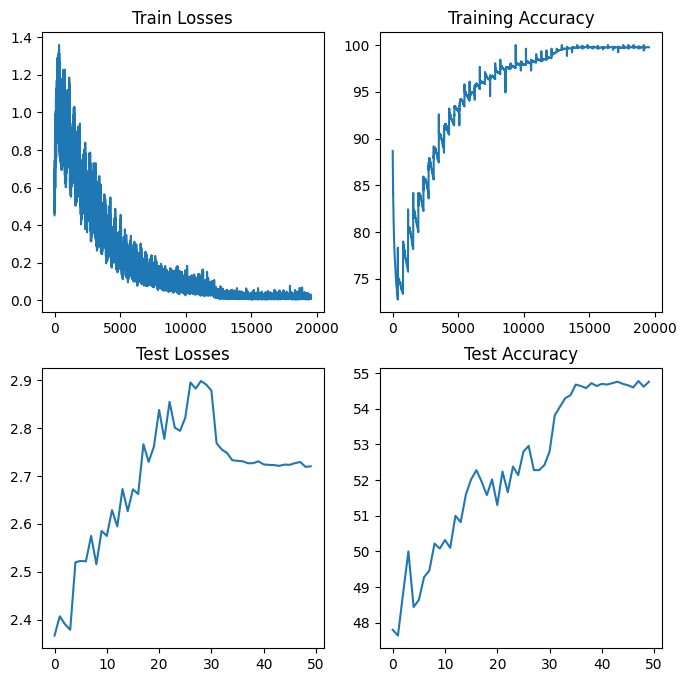

In [8]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)